In [1]:
import os
import argparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from fABBA import JABBA
from fABBA import fABBA
from fABBA import image_compress
from fABBA import image_decompress
import os
import pickle
from sklearn import preprocessing
from sklearn.metrics import matthews_corrcoef, accuracy_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, f1_score
from src.preprocessing import encoders, vector_embed
import torch
import math
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from transformers import AutoTokenizer, DataCollatorWithPadding

import evaluate
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainingArguments, Trainer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import warnings

from utils.data_loader import load_from_tsfile_to_dataframe
from utils.regressor_tools import process_data, fit_regressor, calculate_regression_metrics
from utils.tools import create_directory
from utils.transformer_tools import fit_transformer


2024-06-06 16:19:09.229912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 16:19:10.135694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load data from the TS dataset

In [2]:
warnings.filterwarnings("ignore")


# Python program to convert a list to string
def listToString(s):
    # initialize an empty string
    str1 = ""
    # traverse in the string
    for ele in s:
        str1 += ele + ' '
    # return string
    return str1


data_template = {
    "text": [],
    "labels": [],
}

###############   Time Series Data   ###############

data_name = ['AppliancesEnergy', 'HouseholdPowerConsumption1', 'HouseholdPowerConsumption2', 'BenzeneConcentration',
            'BeijingPM25Quality', 'BeijingPM10Quality', 'LiveFuelMoistureContent', 'FloodModeling1', 'FloodModeling2',
            'FloodModeling3', 'AustraliaRainfall', 'PPGDalia', 'IEEEPPG', 'BIDMCRR', 'BIDMCHR', 'BIDMCSpO2', 'NewsHeadlineSentiment',
            'NewsTitleSentiment', 'Covid3Month']

model_name = 'roberta'
data_folder = 'data/monash-regression/'
train_file = data_folder + data_name[0] + "_TRAIN.ts"
test_file = data_folder + data_name[0] + "_TEST.ts"
    
X_train, y_train = load_from_tsfile_to_dataframe(train_file)
X_test, y_test = load_from_tsfile_to_dataframe(test_file)
norm = "minmax"               # none, standard, minmax

train_test_split = [X_train.shape[0], X_test.shape[0]]
data_all = pd.concat([X_train, X_test])
target_scaled = np.concatenate([y_train, y_test])



# print("[{}] X_train: {}".format(module, X_train.shape))
# print("[{}] X_test: {}".format(module, X_test.shape))

# in case there are different lengths in the dataset, we need to consider that.
# assume that all the dimensions are the same length
# print("[{}] Finding minimum length".format(module))
min_len = np.inf
for i in range(len(data_all)):
    x = data_all.iloc[i, :]
    all_len = [len(y) for y in x]
    min_len = min(min(all_len), min_len)
# print("[{}] Minimum length: {}".format(module, min_len))

# process the data into numpy array with (n_examples, n_timestep, n_dim)
# print("[{}] Reshaping data".format(module))
data_scaled = process_data(data_all, normalise=norm, min_len=min_len)



119it [00:03, 29.80it/s]
66it [00:01, 33.31it/s] 
100%|██████████| 137/137 [00:00<00:00, 761.76it/s]


In [4]:
X_train

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23
0,2016-02-28 17:00:00 21.29 2016-02-28 17:10:...,2016-02-28 17:00:00 31.666667 2016-02-28 17...,2016-02-28 17:00:00 19.890000 2016-02-28 17...,2016-02-28 17:00:00 31.566667 2016-02-28 17...,2016-02-28 17:00:00 20.200000 2016-02-28 17...,2016-02-28 17:00:00 34.230000 2016-02-28 17...,2016-02-28 17:00:00 19.730000 2016-02-28 17...,2016-02-28 17:00:00 31.000000 2016-02-28 17...,2016-02-28 17:00:00 17.390000 2016-02-28 17...,2016-02-28 17:00:00 45.163333 2016-02-28 17...,...,2016-02-28 17:00:00 22.533333 2016-02-28 17...,2016-02-28 17:00:00 34.590000 2016-02-28 17...,2016-02-28 17:00:00 18.500000 2016-02-28 17...,2016-02-28 17:00:00 39.863333 2016-02-28 17...,2016-02-28 17:00:00 5.500000 2016-02-28 17:...,2016-02-28 17:00:00 758.000000 2016-02-28 1...,2016-02-28 17:00:00 50.000000 2016-02-28 17...,2016-02-28 17:00:00 7.000000 2016-02-28 17:...,2016-02-28 17:00:00 40.0 2016-02-28 17:10:0...,2016-02-28 17:00:00 -4.200000 2016-02-28 17:...
1,2016-03-03 17:00:00 21.600000 2016-03-03 17...,2016-03-03 17:00:00 39.110000 2016-03-03 17...,2016-03-03 17:00:00 20.000000 2016-03-03 17...,2016-03-03 17:00:00 37.420000 2016-03-03 17...,2016-03-03 17:00:00 20.600000 2016-03-03 17...,2016-03-03 17:00:00 37.411429 2016-03-03 17...,2016-03-03 17:00:00 21.100000 2016-03-03 17...,2016-03-03 17:00:00 34.556250 2016-03-03 17...,2016-03-03 17:00:00 17.937143 2016-03-03 17...,2016-03-03 17:00:00 44.621429 2016-03-03 17...,...,2016-03-03 17:00:00 21.968571 2016-03-03 17...,2016-03-03 17:00:00 37.000000 2016-03-03 17...,2016-03-03 17:00:00 18.700000 2016-03-03 17...,2016-03-03 17:00:00 41.290000 2016-03-03 17...,2016-03-03 17:00:00 7.000000 2016-03-03 17:...,2016-03-03 17:00:00 749.200000 2016-03-03 1...,2016-03-03 17:00:00 66.000000 2016-03-03 17...,2016-03-03 17:00:00 4.000000 2016-03-03 17:...,2016-03-03 17:00:00 40.0 2016-03-03 17:10:0...,2016-03-03 17:00:00 1.100000 2016-03-03 17:...
2,2016-01-28 17:00:00 19.600000 2016-01-28 17...,2016-01-28 17:00:00 45.090000 2016-01-28 17...,2016-01-28 17:00:00 18.790000 2016-01-28 17...,2016-01-28 17:00:00 44.200000 2016-01-28 17...,2016-01-28 17:00:00 19.823333 2016-01-28 17...,2016-01-28 17:00:00 44.626667 2016-01-28 17...,2016-01-28 17:00:00 18.260000 2016-01-28 17...,2016-01-28 17:00:00 44.026667 2016-01-28 17...,2016-01-28 17:00:00 17.2 2016-01-28 17:10:0...,2016-01-28 17:00:00 52.090000 2016-01-28 17...,...,2016-01-28 17:00:00 19.011111 2016-01-28 17...,2016-01-28 17:00:00 45.102222 2016-01-28 17...,2016-01-28 17:00:00 17.29 2016-01-28 17:10:...,2016-01-28 17:00:00 46.560000 2016-01-28 17...,2016-01-28 17:00:00 5.500000 2016-01-28 17:...,2016-01-28 17:00:00 765.100000 2016-01-28 1...,2016-01-28 17:00:00 77.000000 2016-01-28 17...,2016-01-28 17:00:00 2.0 2016-01-28 17:10:0...,2016-01-28 17:00:00 40.0 2016-01-28 17:10:0...,2016-01-28 17:00:00 1.800000 2016-01-28 17:...
3,2016-03-12 17:00:00 20.600000 2016-03-12 17...,2016-03-12 17:00:00 33.266667 2016-03-12 17...,2016-03-12 17:00:00 19.200000 2016-03-12 17...,2016-03-12 17:00:00 33.500000 2016-03-12 17...,2016-03-12 17:00:00 19.89 2016-03-12 17:10:...,2016-03-12 17:00:00 33.500000 2016-03-12 17...,2016-03-12 17:00:00 20.500000 2016-03-12 17...,2016-03-12 17:00:00 33.090000 2016-03-12 17...,2016-03-12 17:00:00 18.633333 2016-03-12 17...,2016-03-12 17:00:00 41.800000 2016-03-12 17...,...,2016-03-12 17:00:00 25.100000 2016-03-12 17...,2016-03-12 17:00:00 33.290000 2016-03-12 17...,2016-03-12 17:00:00 19.000000 2016-03-12 17...,2016-03-12 17:00:00 39.200000 2016-03-12 17...,2016-03-12 17:00:00 9.80 2016-03-12 17:10:0...,2016-03-12 17:00:00 766.700000 2016-03-12 1...,2016-03-12 17:00:00 50.000000 2016-03-12 17...,2016-03-12 17:00:00 4.000000 2016-03-12 17:...,2016-03-12 17:00:00 25.000000 2016-03-12 17...,2016-03-12 17:00:00 -2.000000e-01 2016-03-12...
4,2016-03-14 17:00:00 22.20 2016-03-14 17:10:...,2016-03-14 17:00:00 34.530000 2

NameError: name 'symbols' is not defined

In [3]:
## init kmeans or agg
## tol： compress rate, lower is better
## k： bigger is better
## scl： vibration rate
## verbose： info
qabba = JABBA(tol=0.005, init='agg', alpha=0.01, scl=3, verbose=0)
# qabba = JABBA(tol=opts.ABBA_tol, init=opts.ABBA_init, k=opts.ABBA_k, scl=opts.ABBA_scl, verbose=0)
symbols = qabba.fit_transform(data_scaled)
# reconst = qabba.inverse_transform(symbols)  # set a shreshold that can optimize the generation
symbols_convert = []
print('##############################################################')
print("The length of used symbols is:" + str(qabba.parameters.centers.shape[0]))

for i_data in range(len(symbols)):
    symbols_convert.append(listToString(list(symbols[i_data])))

train_data_symbolic, test_data_symbolic, train_target_symbolic, test_target_symbolic = symbols_convert[:train_test_split[0]], symbols_convert[train_test_split[0]:], target_scaled[:train_test_split[0]], target_scaled[train_test_split[0]:]

data_TS = DatasetDict({
    'train': Dataset.from_dict({'labels': train_target_symbolic, 'text': train_data_symbolic}),
    'test': Dataset.from_dict({'labels': test_target_symbolic, 'text': test_data_symbolic})
})

# data_CIFAR.save_to_disk(f_hf)



##############################################################
The length of used symbols is:1620


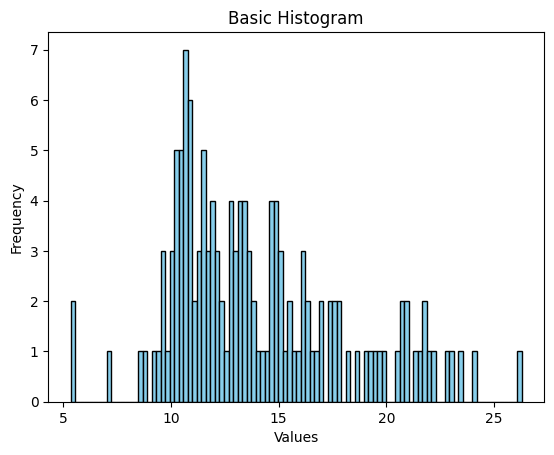

In [4]:

import matplotlib.pyplot as plt
import numpy as np
 
 
# Plotting a basic histogram
plt.hist(target_scaled, bins=100, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')
 
# Display the plot
plt.show()

# Prepare Common LLMs 

In [5]:
warnings.filterwarnings("ignore")


global model_tokenizer
global batch_size
global MAX_LENGTH
global num_classes

MAX_LENGTH = 4096
num_classes = 1
batch_size = 4
# lora config


model_checkpoint = "starmpcc/Asclepius-Llama2-7B"
model_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,
                                                model_max_length=MAX_LENGTH,
                                                padding_side="left",
                                                add_eos_token=True,
                                                add_prefix_space=True)
model_tokenizer.pad_token_id = model_tokenizer.eos_token_id
model_tokenizer.pad_token = model_tokenizer.eos_token


quantization_config = BitsAndBytesConfig(
    # Load the model with 4-bit quantization
    load_in_4bit=True,
    # Use double quantization
    bnb_4bit_use_double_quant=True,
    # Use 4-bit Normal Float for storing the base model weights in GPU memory
    bnb_4bit_quant_type="nf4",
    # De-quantize the weights to 16-bit (Brain) float before the forward/backward pass
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_input = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_checkpoint,
    quantization_config=quantization_config,
    num_labels=num_classes,
    device_map="auto"
)

model_input = prepare_model_for_kbit_training(model_input)

# Data collator for padding a batch of examples to the maximum length seen in the batch
model_data_collator = DataCollatorWithPadding(tokenizer=model_tokenizer)

model_input.config.pad_token_id = model_input.config.eos_token_id

llama_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=64,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
)
model_input = get_peft_model(model_input, llama_peft_config)

model_input.print_trainable_parameters()
model_input = model_input.cuda()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at starmpcc/Asclepius-Llama2-7B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 159,911,936 || all params: 6,767,259,648 || trainable%: 2.3630


In [6]:

def model_preprocessing_function(examples):
    return model_tokenizer(examples['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH)


model_tokenized_datasets = data_TS.map(model_preprocessing_function, batched=True)
model_tokenized_datasets.set_format("torch")

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

In [7]:
from torch.utils.data import DataLoader


# Define the custom collate function
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad or truncate sequences to the same length within each batch
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True)
    attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True)
    labels = torch.stack(labels)

    return {
    'input_ids': input_ids,
    'attention_mask': attention_masks,
    'labels': labels
    }

# Data collator for padding a batch of examples to the maximum length seen in the batch
# model_data_collator = DataCollatorWithPadding(tokenizer=model_tokenizer)
data_loader = DataLoader(model_tokenized_datasets, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


In [8]:
from transformers import Trainer
import torch.nn.functional as F

class MSELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Get model's predictions
        outputs = model(**inputs)      
        logits = outputs.get("logits")
   
        # Compute MSE loss
#         loss = F.mse_loss(logits.squeeze(), labels.float())
        loss = F.mse_loss(logits.squeeze(), labels.float())/batch_size
#         total_loss += loss.item()

        return (loss, outputs) if return_outputs else loss
    

In [ ]:
model_data_collator = DataCollatorWithPadding(tokenizer=model_tokenizer)

project = "ts-finetune-" + data_name[0]
#b-instruct-v0.1-h
base_model_name = "llama2" 
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=5e-4,
    warmup_ratio=0.1,
    max_grad_norm=0.3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    optim="paged_adamw_8bit",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="wandb",
    fp16=True,
    gradient_checkpointing=True,
    save_total_limit=2,
)

trainer_abba = MSELossTrainer(
    model=model_input,
    args=training_args,
    train_dataset=model_tokenized_datasets['train'],
    eval_dataset=model_tokenized_datasets["test"],
    data_collator=model_data_collator,
#     compute_metrics=compute_metrics,
)
trainer_abba.train()

# torch.cuda.empty_cache()
del model_input
# del model_tokenized_datasets
# del data_UCR

In [10]:
from peft import PeftModel
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

del model_input
num_classes = 1
base_model_id = "starmpcc/Asclepius-Llama2-7B"

base_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=base_model_id,
    num_labels=num_classes,
    device_map="auto"
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)

# base_model = base_model.cuda()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at starmpcc/Asclepius-Llama2-7B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: You can't move a model that has some modules offloaded to cpu or disk.

In [11]:
base_model = PeftModel.from_pretrained(base_model, "llama2-ts-finetune-AppliancesEnergy/checkpoint-72/")

In [12]:
for i_test in range(len(data_TS['test']['text'])):
    print('#######################################################################')
    model_input_text = eval_tokenizer(data_TS['test']['text'][i_test], return_tensors="pt").to('cuda')

    outputs = base_model(input_ids=model_input_text['input_ids'], attention_mask=model_input_text['attention_mask'])
    logits = outputs.logits.squeeze()
    predictions = logits.detach().cpu().numpy()

    print('prediction: ' + str(predictions))
    print('real: ' + str(data_TS['test']['labels'][i_test]))

Token indices sequence length is longer than the specified maximum sequence length for this model (5811 > 4096). Running this sequence through the model will result in indexing errors


#######################################################################
prediction: 12.596839
real: 17.37
#######################################################################
prediction: 12.286289
real: 20.65
#######################################################################
prediction: 12.406353
real: 11.42
#######################################################################
prediction: 12.456167
real: 10.68
#######################################################################
prediction: 12.288422
real: 12.44
#######################################################################
prediction: 12.834539
real: 11.17
#######################################################################
prediction: 12.408128
real: 24.12
#######################################################################
prediction: 12.46322
real: 10.99
#######################################################################
prediction: 12.478753
real: 13.76
###############################################